In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
print(tf.__version__)

2.13.0


In [4]:
BATCH_SIZE = 32     #Badge of 32 images at every training iteration
IMAGE_SIZE = 224    #Image dimention
CHANNELS =3         #indicating three colours RGB
EPOCHS = 50         #number of times the model will iterate through the entire dataset during training

Importing data into tensorflow dataset object

In [5]:
#This function is used to download image datasets from direcory
#Resizing image 224x224 pixel
#image_dataset_from_directory is an API to load all images in tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Disease",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE), 
    batch_size=BATCH_SIZE
)

Found 838 files belonging to 5 classes.


In [6]:
class_names = dataset.class_names
class_names

['Alternaria', 'Anthracnose', 'Black Mould Rot', 'Healthy', 'Stem and Rot']

In [7]:
#total 27 batches of 32 images

In [8]:
len(dataset)

27

In [9]:
27*32  ##because every element of dataset is a badge 32 elements

864

In [10]:
#to extract and print information about the first batch of data
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 3 3 2 3 4 0 3 4 1 2 3 4 3 2 0 4 2 4 3 3 0 0 0 3 2 0 3 1 4 3 0]


In [11]:
#prints the shape of the first image
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape) #indexed using 0 

(224, 224, 3)


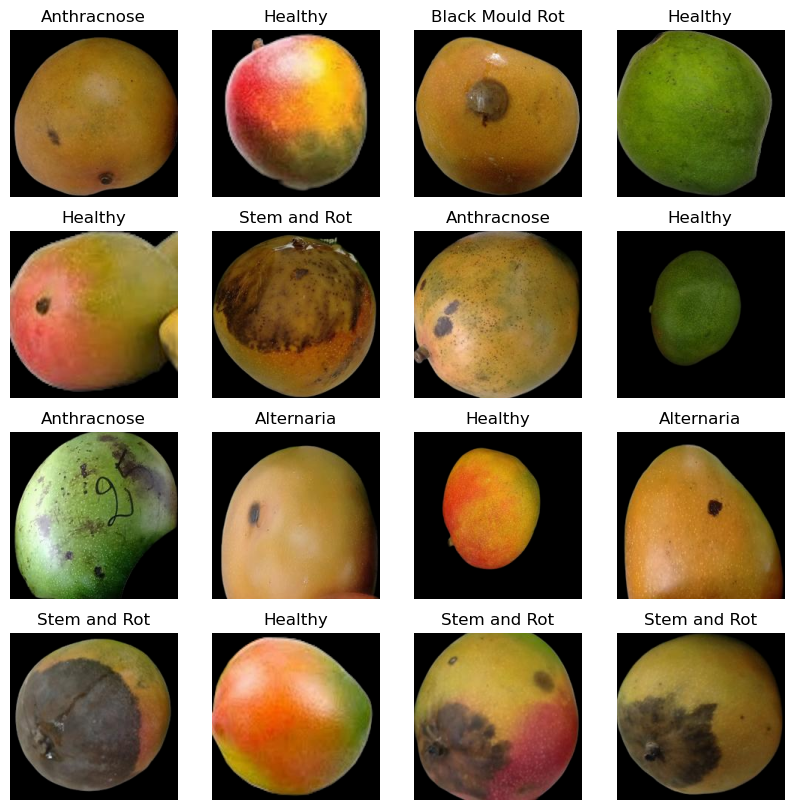

In [12]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))   #figure size of 10x10 inches

for image_batch, label_batch in dataset.take(1):
    for i in range(16):              #to display a grid of 16 images iterates 16 times
        ax = plt.subplot(4, 4, i+1)  #grid is organized as a 4x4 matrix  
        plt.imshow(image_batch[i].numpy().astype("uint8"))  #ensure that pixel values are treated 8bit unsigned-int
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [13]:
#80% ==> training
#20% ==> 10% validation, 10% test

In [14]:
#fraction of traning dataset is 0.8=80%
train_size = 0.8
len(dataset)*train_size

21.6

In [15]:
len(dataset)

27

In [16]:
train_ds =dataset.take(21)
len(train_ds)

21

In [17]:
#
test_ds= dataset.skip(21)
len(test_ds)

6

In [18]:
val_size=0.1
len(dataset)*val_size

2.7

In [19]:
test_ds = test_ds.skip(2)
len(test_ds)

4

Training,Testing and Validation Splitting

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [34]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [35]:
len(train_ds)/21

1.0

In [38]:
len(val_ds)/2

1.0

In [39]:
len(test_ds)/4

1.0

# Image Preprocessing

Cache, Shuffle, and Prefetch the Dataset

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
#Layer for resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])



In [42]:
#Dta augmentation-- Is needed when we have less data ,this boosts the accuracy of our modelby augmenting the data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])


In [43]:
#Applying augmentation to Train dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build and Train CNN Model, Model Architecture

In [44]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

# Note: You don't need to explicitly call model.build() if you're using Sequential model and specifying the input shape in the first layer.
# model.build(input_shape=input_shape)

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 111, 111, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 52, 52, 64)         

Compiling the Model

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
# Assuming train_ds and val_ds are TensorFlow Dataset objects

# Extract a batch of data from the training dataset
for input_data, target_data in train_ds.take(1):
    print("Shape of training input data:", input_data.shape)
    print("Shape of training target data:", target_data.shape)

# Extract a batch of data from the validation dataset
for input_data, target_data in val_ds.take(1):
    print("Shape of validation input data:", input_data.shape)
    print("Shape of validation target data:", target_data.shape)


Shape of training input data: (32, 224, 224, 3)
Shape of training target data: (32,)
Shape of validation input data: (32, 224, 224, 3)
Shape of validation target data: (32,)


In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50
21/21 [==============================] - 64s 3s/step - loss: 1.5833 - accuracy: 0.2399 - val_loss: 1.4356 - val_accuracy: 0.3281
Epoch 2/50
21/21 [==============================] - 73s 3s/step - loss: 1.3238 - accuracy: 0.3777 - val_loss: 1.1934 - val_accuracy: 0.4375
Epoch 3/50
21/21 [==============================] - 73s 3s/step - loss: 1.2125 - accuracy: 0.4985 - val_loss: 1.1140 - val_accuracy: 0.4688
Epoch 4/50
21/21 [==============================] - 71s 3s/step - loss: 1.0526 - accuracy: 0.5526 - val_loss: 0.9514 - val_accuracy: 0.5469
Epoch 5/50
21/21 [==============================] - 65s 3s/step - loss: 0.9492 - accuracy: 0.6223 - val_loss: 0.8321 - val_accuracy: 0.6250
Epoch 6/50
21/21 [==============================] - 49s 2s/step - loss: 0.9366 - accuracy: 0.6300 - val_loss: 0.8164 - val_accuracy: 0.6719
Epoch 7/50
21/21 [==============================] - 48s 2s/step - loss: 0.9141 - accuracy: 0.6502 - val_loss: 0.9969 - val_accuracy: 0.5625
Epoch 8/50
18/21 [==

In [44]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 2s 456ms/step - loss: 0.5218 - accuracy: 0.8529


Scores

Plotting the Accuracy and Loss Curve

In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 21}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [48]:
type(history.history['loss'])

list

In [49]:
len(history.history['loss'])

50

In [50]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6278817057609558,
 0.60133296251297,
 0.607580840587616,
 0.6108782291412354,
 0.6785126328468323]

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

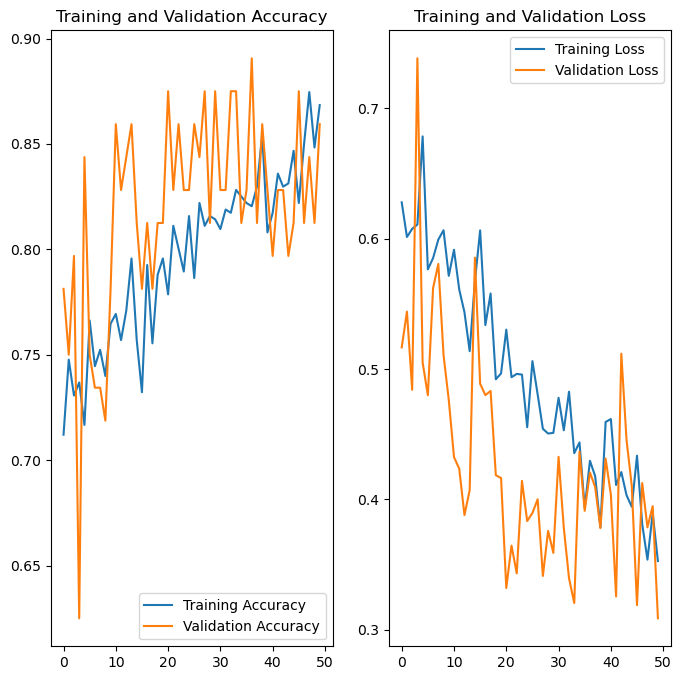

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Anthracnose
1/1 [==============================] - 1s 771ms/step
predicted label: Anthracnose


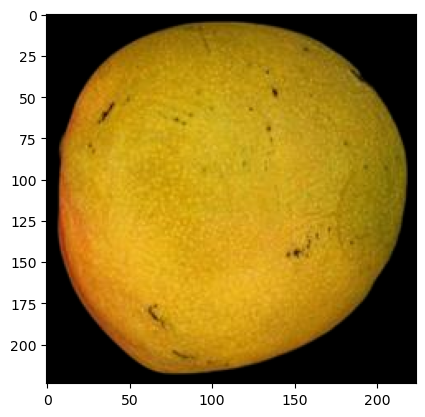

In [66]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

inference on few sample images

1/1 [==============================] - 0s 62ms/step


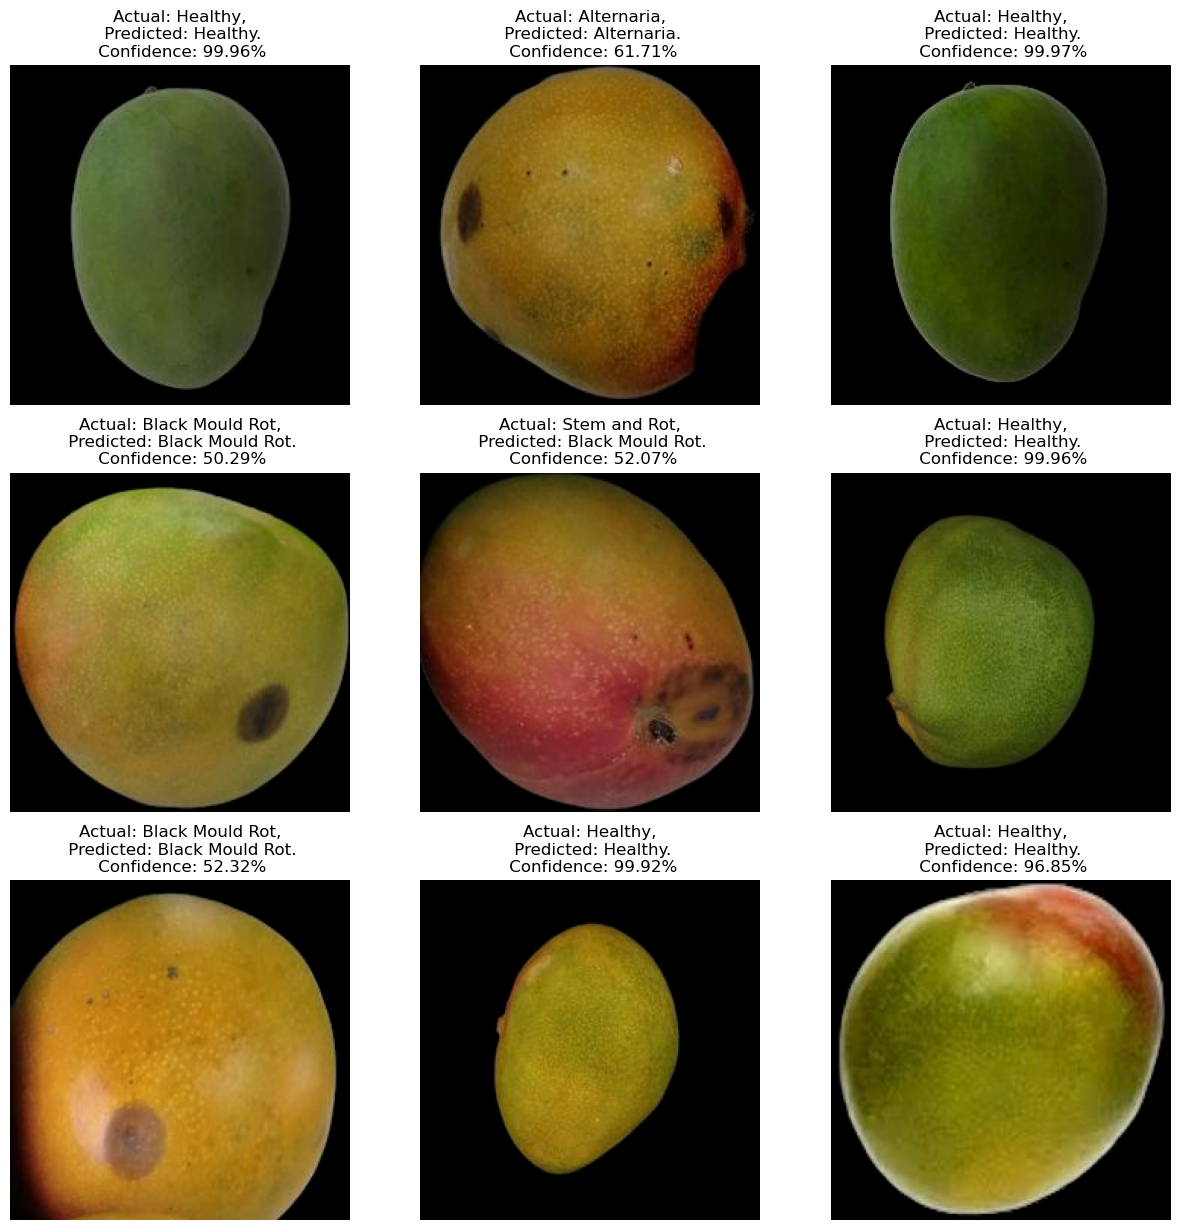

In [67]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")